In [2]:
import itertools

import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.cluster import AffinityPropagation

import matplotlib.pyplot as plt
%matplotlib inline


dataset = '../dns_final.csv'
anchor_file = '../anchor.csv'

In [3]:
df = pd.read_csv(dataset)
anchor = pd.read_csv(anchor_file)

In [18]:
df_sample = np.random.choice(df.index.values, 1000)
#ar = np.array(df.ix[df_sample])
ar = df.as_matrix()
anchor_sample = np.random.choice(anchor.index.values, 10)
ar = np.concatenate((ar, np.array(anchor.ix[anchor_sample])), axis=0)

In [6]:
af = AffinityPropagation().fit(ar)

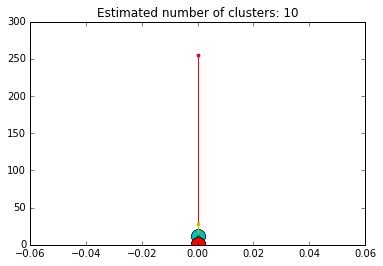

In [7]:
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)

plt.close('all')
plt.figure(1)
plt.clf()

colors = itertools.cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = ar[cluster_centers_indices[k]]
    plt.plot(ar[class_members, 0], ar[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in ar[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [8]:
cluster_centers_indices

array([  2,  26,  40,  42,  45,  55,  73,  96, 103, 104])

In [9]:
labels

array([6, 5, 0, 2, 7, 5, 7, 6, 7, 2, 1, 2, 7, 2, 2, 0, 2, 5, 8, 7, 0, 0, 5,
       6, 5, 6, 1, 6, 2, 2, 0, 5, 2, 6, 1, 0, 6, 7, 5, 7, 2, 0, 3, 7, 2, 4,
       6, 2, 5, 7, 2, 0, 5, 6, 5, 5, 7, 7, 1, 7, 5, 2, 0, 7, 5, 0, 0, 7, 0,
       2, 5, 3, 3, 6, 7, 7, 6, 2, 6, 3, 7, 0, 7, 7, 6, 0, 1, 7, 7, 6, 7, 1,
       0, 3, 1, 6, 7, 1, 5, 5, 9, 9, 8, 8, 9])

# Mean Shift

Attempt again using MeanShift

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(ar, quantile=0.2)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(ar)

labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

colors = itertools.cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(ar[my_members, 0], ar[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
len(ar)

In [17]:
len(df)

165740